In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar  4 22:26:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    52W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install torch_utils

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# House Keeping
import os
import glob
from PIL import Image
from timeit import default_timer as timer

# Deep learning tools
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import cuda
from torch.utils.data import TensorDataset, DataLoader, sampler
from torch_utils import AverageMeter
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Visualizations and Image tools
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import random_noise
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
def img_preprocessing(image_list, label):
  first_img = cv2.imread(image_list[0])
  first_img = cv2.resize(first_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  fist_img = np.asarray(first_img)
  imgs_resized = np.expand_dims((first_img), axis = 0)

  for img in image_list:
    #read in the normal image
    img = cv2.imread(img)
    img =  cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    img_array = np.asarray(img)
    img_array = np.expand_dims(img_array, axis = 0)
    imgs_resized = np.vstack((imgs_resized, img_array))
    
    #add a rotated image
    img_rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img_array = np.asarray(img_rotated)
    img_array = np.expand_dims(img_array, axis = 0)
    imgs_resized = np.vstack((imgs_resized, img_array))

    #add a noisy image
    gauss = np.random.normal(0, .7, img.shape).astype('uint8')
    img_noisy = cv2.add(img, gauss)
    img_array = np.asarray(img_noisy)
    img_array = np.expand_dims(img_array, axis = 0)
    imgs_resized = np.vstack((imgs_resized, img_array))

    #add a perspective transform
    pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
    pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])
    trans_matrix = cv2.getPerspectiveTransform(pts1,pts2)
    img_transform = cv2.warpPerspective(img, trans_matrix, (224,224))
    img_transform = np.asarray(img_transform)
    img_array = np.expand_dims(img_transform, axis = 0)
    imgs_resized = np.vstack((imgs_resized, img_array))
    
    #add a warped image
    trans_matrix = np.float32([[1,0,100],[0,1,50]])
    img_warped = cv2.warpAffine(img, trans_matrix,(224,224))
    img_warped = np.asarray(img_warped)
    img_array = np.expand_dims(img_warped, axis = 0)
    imgs_resized = np.vstack((imgs_resized, img_array))
    
  #create labels for all the images
  img_labels = np.expand_dims(np.array([label] * len(imgs_resized)),axis = 1)

  return imgs_resized, img_labels

In [ ]:
border_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/BorderCollie/*")
border_imgs, border_labels = img_preprocessing(border_jpgs, 0)

cat_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/Cat/*")
cat_imgs, cat_labels = img_preprocessing(cat_jpgs, 1)

corgi_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/Corgi/*")
corgi_imgs, corgi_labels = img_preprocessing(corgi_jpgs, 2)

lab_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/Lab/*")
lab_imgs, lab_labels = img_preprocessing(lab_jpgs, 3)

dalmatian_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/Dalmatian/*")
dalmatian_imgs, dalmatian_labels = img_preprocessing(dalmatian_jpgs, 4)

golden_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/Golden/*")
golden_imgs, golden_labels = img_preprocessing(golden_jpgs, 5)

greyhound_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/Greyhound/*")
greyhound_imgs, greyhound_labels = img_preprocessing(greyhound_jpgs, 6)

husky_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/Husky/*")
husky_imgs, husky_labels = img_preprocessing(husky_jpgs, 7)

newfie_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/Newfoundland/*")
newfie_imgs, newfie_labels = img_preprocessing(newfie_jpgs, 8)


toller_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/Toller/*")
toller_imgs, toller_labels = img_preprocessing(toller_jpgs, 9)

In [ ]:
categories = {0:"Border", 1:"Cat", 2:"Corgi", 3:"Lab", 4:"Dalmatian", 5 :"Golden", 6:"GreyHound", 7:"Husky", 8:"Newfie", 9:"Toller"}

In [ ]:
#combine data and set axis to expected values for model
train_x = np.vstack((border_imgs, cat_imgs, corgi_imgs, lab_imgs, dalmatian_imgs, golden_imgs, greyhound_imgs, husky_imgs, newfie_imgs, toller_imgs))
train_x = train_x.transpose(0, 3, 1, 2)

#combine labels and remove the extra dim
train_y = np.squeeze(np.vstack((border_labels, cat_labels, corgi_labels, lab_labels, dalmatian_labels, golden_labels, greyhound_labels, husky_labels, newfie_labels, toller_labels)))


In [ ]:
#do a 80 20 split
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2)

In [ ]:
# Datasets organization
batch_size = 256

# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y).float()),
    'valid':
    TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y).float())
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=1),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True, num_workers=1)       
}

trainloader = dataloaders["train"]
validloader = dataloaders["valid"]

In [ ]:
model = torchvision.models.densenet121(pretrained = True)

# Uncomment for feature extraction vs transfer learning
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
                      nn.Linear(num_ftrs, 512),
                      nn.ReLU(),
                      nn.Linear(512, 150),
                      nn.ReLU(),
                      nn.Linear(150, 25),
                      nn.ReLU(),
                      nn.Linear(25, 10))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = .01)
n_epochs = 500

In [ ]:
%%capture
# House Keeping
start = timer()
history = []
best_acc = 1/ len(np.unique(val_y))
no_improvement = 0

# Main loop
for epoch in range(n_epochs):

  # keep track of training and validation loss each epoch
  train_acc = 0
  valid_acc = 0

  # Set to training
  model.train()        

  # Training loop
  for ii, (data, target) in enumerate(trainloader):
      
      #switch to cuda
      model = model.cuda()
      data, target = data.cuda(), target.cuda()
      
      # Clear gradients
      optimizer.zero_grad()

      # Get your output from your model     
      model = model.float()
      output = model(data.float())

      # Loss and backpropagation of gradients        
      loss = criterion(output, target.long())
      loss.backward()
      optimizer.step()
              
      # Calculate accuracy by finding max log probability        
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(target.data.view_as(pred))
      
      # Need to convert correct tensor from int to float to average       
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
      
      # Multiply average accuracy times the number of examples in batch
      train_acc += accuracy.item() * data.size(0) / len(trainloader.dataset)

  # Eval loop
  model.eval();  
  for data, target in validloader:
      
      #switch to cuda
      model = model.cuda()
      data, target = data.cuda(), target.cuda()

      # Get your output from your model     
      model = model.float()
      output = model(data.float())
      
      # Calculate accuracy by finding max log probability        
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(target.data.view_as(pred))
      
      # Need to convert correct tensor from int to float to average       
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
      
      # Multiply average accuracy times the number of examples in batch
      valid_acc += accuracy.item() * data.size(0) / len(validloader.dataset)
  
  # Track the training
  history.append([train_acc, valid_acc])

  if valid_acc > best_acc:

    # Load the best state dict                        
    torch.save(model.state_dict(), "/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Best_Pet_Classifier.pt")
    best_acc = valid_acc

    # Track the epoch it occured
    no_improvement = 0

  # If the model hasnt improved in 20 epochs exit early
  else:
    no_improvement += 1 

  if no_improvement > 10:
    break


history = pd.DataFrame(history, columns=['train_acc', 'valid_acc'])    
end = timer()
print("Total Time: ", end - start)

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

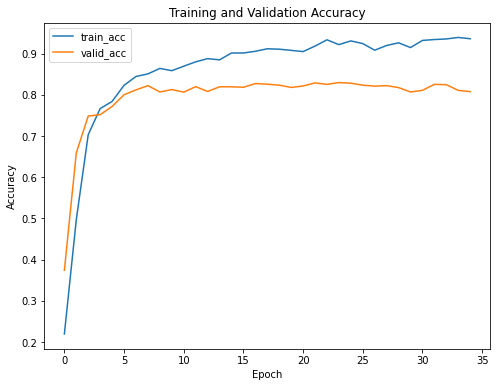

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
model = torchvision.models.densenet121(pretrained = True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
                      nn.Linear(num_ftrs, 512),
                      nn.ReLU(),
                      nn.Linear(512, 150),
                      nn.ReLU(),
                      nn.Linear(150, 25),
                      nn.ReLU(),
                      nn.Linear(25, 10))

model.load_state_dict(torch.load(("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Best_Pet_Classifier.pt")))
model.cuda()
model.eval()

<All keys matched successfully>

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = npimg.transpose(1,2,0)

    plt.imshow(npimg)
    plt.show()

validationiter = iter(dataloaders['valid'])
dataiter = iter(validationiter)

images, labels = dataiter.next()

outputs = model(images.float())
_, predicted = torch.max(outputs, 1)

for i in range(0,len(labels)):
  print("Ground Truth:",categories.get(labels[i].item()), " \tPrediction: ",categories.get(predicted[i].item()), '\n')

In [ ]:
def img_loading(image_list):
  first_img = cv2.imread(image_list[0])
  first_img = cv2.resize(first_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  fist_img = np.asarray(first_img)
  imgs_resized = np.expand_dims((first_img), axis = 0)

  for img in image_list:
    #read in the normal image
    img = cv2.imread(img)
    img =  cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    img_array = np.asarray(img)
    img_array = np.expand_dims(img_array, axis = 0)
    imgs_resized = np.vstack((imgs_resized, img_array))
  
  return imgs_resized[1:]


In [ ]:
test_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/zReal_Pets/Livy/*")
test_imgs = img_loading(test_jpgs)

test_x = test_imgs
test_x = test_x.transpose(0, 3, 1, 2)

# Transfer the data from numpy to tensor
data = {
    'test':
    TensorDataset(torch.from_numpy(test_x))
}

batch_size = test_imgs.shape[0]
# Dataloader iterators, make sure to shuffle
dataloaders = {
    'test': DataLoader(data['test'], batch_size = batch_size, num_workers=1),     
}

testloader = dataloaders["test"]

Text(0.5, 1.0, 'Corgi')

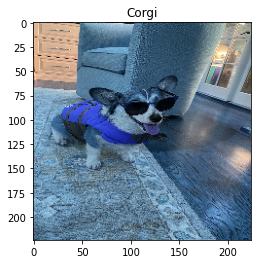

Text(0.5, 1.0, 'Corgi')

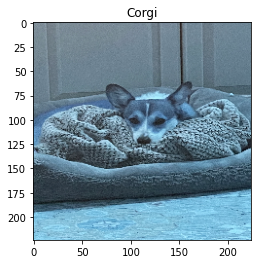

Text(0.5, 1.0, 'Corgi')

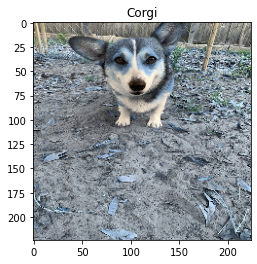

Text(0.5, 1.0, 'Corgi')

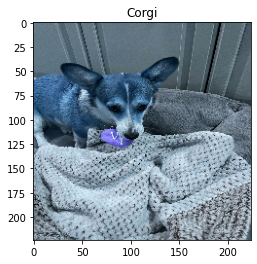

In [ ]:
testiter = iter(dataloaders['test'])
dataiter = iter(testiter)

images = dataiter.next()[0]

outputs = model(images.cuda().float())
_, predicted = torch.max(outputs, 1)

for i in range(0,len(images)):
  plt.imshow(images[i].numpy().transpose(1, 2, 0))
  plt.title(categories.get(predicted[i].item()))
  plt.show()

In [ ]:
test_jpgs = glob.glob("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/zReal_Pets/Apollo/*")
test_imgs = img_loading(test_jpgs)

test_x = test_imgs
test_x = test_x.transpose(0, 3, 1, 2)

# Transfer the data from numpy to tensor
data = {
    'test':
    TensorDataset(torch.from_numpy(test_x))
}

batch_size = test_x.shape[0]
# Dataloader iterators, make sure to shuffle
dataloaders = {
    'test': DataLoader(data['test'], batch_size = batch_size, num_workers=1),     
}

testloader = dataloaders["test"]

Text(0.5, 1.0, 'Cat')

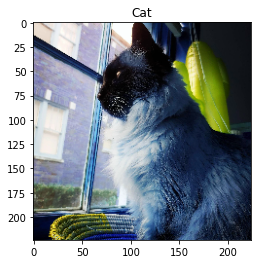

Text(0.5, 1.0, 'Cat')

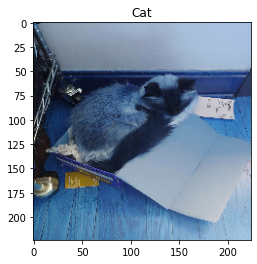

Text(0.5, 1.0, 'Corgi')

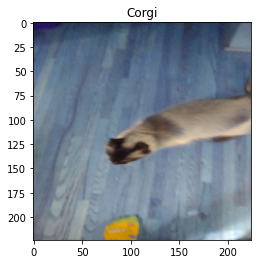

Text(0.5, 1.0, 'Border')

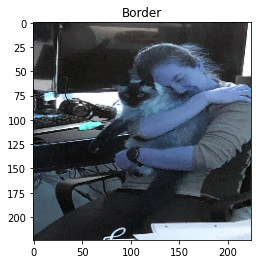

In [ ]:
testiter = iter(dataloaders['test'])
dataiter = iter(testiter)

images = dataiter.next()[0]

outputs = model(images.cuda().float())
_, predicted = torch.max(outputs, 1)

for i in range(0,len(images)):
  plt.imshow(images[i].numpy().transpose(1, 2, 0))
  plt.title(categories.get(predicted[i].item()))
  plt.show()